Single Image URL Analysis
* Able to analyze if the URL is valid
* Able to analyze if the image require cropping
* Able to analyze the quality of the image resolution
* Able to know if the image type is supported. Obtain the image data type, such as jpeg
* Extra information to know if the image is single product image with white background or it is scene image (Estimated 98% accuracy)

Future Work On
* Should be able to find out if it is an "No Image" image

In [1]:
import cv2 
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
supported_types = ['image/png', 'image/jpeg', 'image/jpg']
def findBox(img, estimate = False, bounds = None, tolerance = 1):
    rows, cols = img.shape
    if rows < 200 or cols < 200:
        return (0,cols-1,0,rows-1)
    
    left_bound, right_bound, upper_bound, lower_bound = 0,cols-1,0,rows-1
    if bounds:
        left_bound, right_bound, upper_bound, lower_bound = bounds
        
    step, shift = 1, 0
    
    if estimate:
        step = int(min(rows, cols)/100)
        shift = step

    for i in range(upper_bound, rows, step):
        value = round(sum(img[i, :])/cols, 2)
        if value < 255 - tolerance:
            upper_bound = i
            break
    
    for i in range(lower_bound, 0, -step):
        value = round(sum(img[i, :])/cols, 2)
        if value < 255 - tolerance:
            lower_bound = i
            break
            
    for j in range(left_bound, cols, step):
        value = round(sum(img[:, j])/rows, 2)
        if value  < 255 - tolerance:
            left_bound = j
            break
            
    for j in range(right_bound, 0, -step):
        value = round(sum(img[:, j])/rows, 2)
        if value < 255 - tolerance:
            right_bound = j
            break
    
    #prevent from going out of boundary
    if estimate:
        left_bound =  (left_bound - shift if left_bound - shift >= 0 else 0)
        right_bound = (right_bound + shift if right_bound + shift < cols else cols-1)     
        upper_bound = (upper_bound - shift if upper_bound - shift >= 0 else 0)
        lower_bound = (lower_bound + shift if lower_bound + shift < rows else rows-1)

    left_bound =  (left_bound if left_bound >= 0 else 0)
    right_bound = (right_bound if right_bound < cols else cols-1)
    upper_bound = (upper_bound if upper_bound >= 0 else 0)
    lower_bound = (lower_bound if lower_bound < rows else rows-1)
      
    if left_bound >= right_bound or upper_bound >= lower_bound:
        return (0,cols-1,0,rows-1)
    return (left_bound, right_bound, upper_bound, lower_bound)
    

def build_histgram(hist, key):
    if key in hist:
        hist[key] += 1
    else:
        hist[key] = 1

def findBound(img):
    bounds = findBox(img, estimate = True)
    left_bound, right_bound, upper_bound, lower_bound = findBox(img, bounds=bounds)
    
    # Identify Scene Image
    """
    Algorithm Concept
    Old:
    On the boundary line, if there are all non white points, it is scene image
    Otherwise it is single product image with white background
    
    New Version:
    1. If the boundary is at edge, ignore white pixels
    2. Otherwise, if more than 1 non white pixels, identify it as "Not Scene" image
    
    """
    boudary_pixels = (lower_bound - upper_bound + 1)*2 + (right_bound - left_bound + 1)*2
    histogram = {}
    for x in range(upper_bound, lower_bound):
        left_pixel = img[x, left_bound]
        right_pixel = img[x, right_bound]
        build_histgram(histogram, left_pixel)
        build_histgram(histogram, right_pixel)
        
    for y in range(left_bound, right_bound):
        up_pixel = img[upper_bound, y]
        low_pixel = img[lower_bound, y]
        build_histgram(histogram, up_pixel)
        build_histgram(histogram, low_pixel)
    
    white_pixel_count = 0
    for k in histogram:
        if k >= 254:
            white_pixel_count += histogram[k]
    
    #print(histogram)
    non_white_pixels_percent = (boudary_pixels-white_pixel_count)/boudary_pixels
    print('non white pixels percentage: ' + str(non_white_pixels_percent))
    
    return [upper_bound, lower_bound, left_bound, right_bound, non_white_pixels_percent > 0.5]

def isLargeMargin(img_area, box_area, threshold = 1): # If padding area is larger than 30% , then requires crop
    percent = round((img_area-box_area)/box_area, 3)
    print('Padding Area is ' + str(round(percent*100,2)) + '%')
    return  percent > threshold, percent

def padding(img, marginPercent = 0.05):
    rows, cols, _ = img.shape
    square_length = int(max(rows, cols) * (1 + marginPercent))
    white_img = np.zeros([square_length, square_length,3], dtype=np.uint8)
    white_img.fill(255)
    
    row_gap = int((square_length - rows)/2)
    col_gap = int((square_length - cols)/2)

    white_img[row_gap:(row_gap + rows), col_gap:(col_gap + cols)] = img
    return white_img

* Status_Code: The actual status code returned from internet connection response, 200 is valid
* Require_Crop:  The image has too much large white margin, requires image cropping, default threshold is 100%
* Low_Resolution: The longest height/width is less than 1200
* Not_Image: It is an image, but not a product image

- Padding_Percent: Caculated (Padding area/Product Area) ratio 
- is_Scene: It is scene image or product image with white background
- Image_DataType: The image data type from headers in internet response, such as "image/jpeg"
- Image_Shape: Contains the actual image RGB data matrix shape 

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests

def analyzeImage(url, downloadContent = True):
    #white_margin_percent = 0.05
    result = {   'URL_Status_Code':None, # Integer                              *
           'Invalid_ContentLength':True, # Boolean, url contains content length *
                 'Low_Resolution':False, # Boolean                              *
              'Resolution_TooHigh':None, # Boolean                              *
                    #'Not_Image':None, # Boolean   It is a "No Image" image   * disabled
          'Unsupported_ImageType':False, # Boolean                              *
                    'Require_Crop':None, # Boolean  require crop or not         *
                  
           'Padding_Percent':None, # Float, caculated (Padding area/Product Area) ratio
                  'is_Scene':None, # Boolean, if it is a scene image
            'Image_DataType':None, # String, such as image/jpeg
               'Image_Shape':None  # Tuple,  contains image shape
             }
    try:
        response = requests.get(url, stream=True)
        result['URL_Status_Code'] = response.status_code
    except Exception as e:
        print("error:", e)
        result={}
        result['Error'] = e
        result['statusCode'] = 404
        return result
    
    ContentType = None
    if 'Content-Type' in response.headers:
        ContentType = response.headers['Content-Type']
#     for k in response.headers:
#         print(response.headers[k])
    if 'Content-Length' in response.headers:
        content_len = response.headers['Content-Length']
        print('Content Length: ' + str(content_len))
        if isinstance(content_len, str) and content_len.isdigit() and int(content_len) > 0:
            result['Invalid_ContentLength'] =  False
        if isinstance(content_len, int) and content_len > 0:
            result['Invalid_ContentLength'] =  False
    print(result['Invalid_ContentLength'])
    if ContentType:
        result['Unsupported_ImageType'] = ContentType.lower() not in supported_types
    
    if not result['Invalid_ContentLength'] and downloadContent and response.status_code == 200:
        content = response.raw
        img = np.asarray(bytearray(content.read()), dtype="uint8")
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        upper, lower, left, right, result['is_Scene'] = findBound(gray_img)
        x1 = left
        y1 = upper
        x2 = right
        y2 = lower
        print(url)
        rows, cols, _ = img.shape
        result['Resolution_TooHigh'] = rows*cols/1000000 >= 100 # Maximum resolution: 100 Mpx (width x height. Eg. 10000 x 10000 px for 1.0 aspect ratio)
        result['Image_DataType'] = ContentType
        result['Image_Shape'] = img.shape
        
        if rows < 1200 and cols < 1200:
            result['Low_Resolution'] = True
            
        result['Require_Crop'], result['Padding_Percent'] = isLargeMargin((rows-1)*(cols-1), (x2-x1)*(y2-y1))
        result['Bound_Box'] = [(x1, y1), (x2, y2)]
        if not result['Require_Crop'] and result['is_Scene']:
            result['Require_Crop'] = not (x1 == 0 and x2 == cols-1 and y1 == 0 and y2 == rows-1)
        result['statusCode'] = 200
        
        
        f= plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
        f.add_subplot(1,3, 1)
        plt.imshow(img)
        new_img = img.copy()
        new_img = cv2.rectangle(new_img, (x1,y1), (x2, y2), (255,0,0), int(rows/100)) 

        f.add_subplot(1,3, 2)
        plt.imshow(new_img)
        plt.show()
        
    for k in result:
        print(str(k) + ':' +str(result[k]))


Content Length: 995
False
non white pixels percentage: 0.0225
https://www.whirlpool.com/is/image/content/dam/global/shot-lists/2018/p180359/6802a/hero-6802a-1.tif?$mdm-thumb-100$
Padding Area is 0.0%


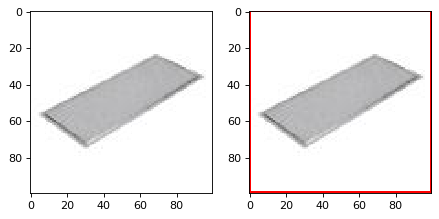

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:True
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:False
Padding_Percent:0.0
is_Scene:False
Image_DataType:image/jpeg
Image_Shape:(100, 100, 3)
Bound_Box:[(0, 0), (99, 99)]
statusCode:200


In [3]:
small_img = 'https://www.whirlpool.com/is/image/content/dam/global/shot-lists/2018/p180359/6802a/hero-6802a-1.tif?$mdm-thumb-100$'
analyzeImage(small_img)

Content Length: 1068598
False
non white pixels percentage: 0.033481101259916005
http://access.whirlpool.com/mr/getMediaType.do?mediaType=Original&sku=8212638RC
Padding Area is 25.8%


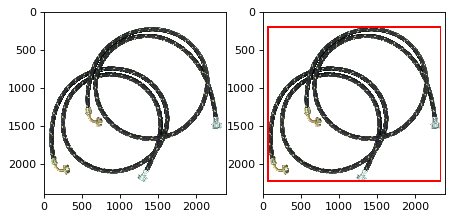

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:False
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:False
Padding_Percent:0.258
is_Scene:False
Image_DataType:image/jpeg
Image_Shape:(2400, 2400, 3)
Bound_Box:[(66, 210), (2327, 2233)]
statusCode:200


In [4]:
large_img = 'http://access.whirlpool.com/mr/getMediaType.do?mediaType=Original&sku=8212638RC'
analyzeImage(large_img)

In [5]:
forbidden = 'https://natureconservancy-h.assetsadobe.com/is/image/content/dam/tnc/nature/en/photos/tnc_985621561.jpg?crop=0,0,3000,1650&wid=4000&hei=2200&scl=0.75|'
analyzeImage(forbidden)

Content Length: 27
False
URL_Status_Code:403
Invalid_ContentLength:False
Low_Resolution:False
Resolution_TooHigh:None
Unsupported_ImageType:True
Require_Crop:None
Padding_Percent:None
is_Scene:None
Image_DataType:None
Image_Shape:None


In [6]:
room_place = 'https://cdn-tp4.mozu.com/25920-39845/cms/39845/files/18becab3-ce6c-4d1a-ab85-dd3af491f400'
analyzeImage(room_place)

True
URL_Status_Code:200
Invalid_ContentLength:True
Low_Resolution:False
Resolution_TooHigh:None
Unsupported_ImageType:False
Require_Crop:None
Padding_Percent:None
is_Scene:None
Image_DataType:None
Image_Shape:None


Content Length: 116304
False
non white pixels percentage: 0.9716870986573263
https://ck-datasource-manual.s3.us-east-1.amazonaws.com/theRoomPlace/D5070000066_0.jpeg
Padding Area is 0.0%


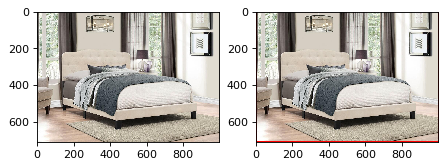

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:True
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:False
Padding_Percent:0.0
is_Scene:True
Image_DataType:image/jpeg
Image_Shape:(714, 999, 3)
Bound_Box:[(0, 0), (998, 713)]
statusCode:200


In [7]:
scene_image = 'https://ck-datasource-manual.s3.us-east-1.amazonaws.com/theRoomPlace/D5070000066_0.jpeg'
analyzeImage(scene_image)

Content Length: 129563
False
non white pixels percentage: 0.3274950429610046
https://wondersign.s3-us-west-1.amazonaws.com/cropped_image/38709.jpg
Padding Area is 59.9%


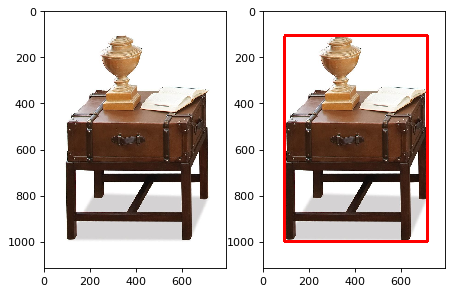

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:True
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:False
Padding_Percent:0.599
is_Scene:False
Image_DataType:image/jpeg
Image_Shape:(1116, 792, 3)
Bound_Box:[(94, 107), (711, 1001)]
statusCode:200


In [8]:
large_margin = 'https://wondersign.s3-us-west-1.amazonaws.com/cropped_image/38709.jpg'
analyzeImage(large_margin)

In [9]:
not_available = 'https://www.whirlpool.com/is/imagel/content/dam/global/shot-lists/2019/f190004/hero-f190004-438.tif?$mdm-thumb-290$'
analyzeImage(not_available)

Content Length: 70720
False
URL_Status_Code:404
Invalid_ContentLength:False
Low_Resolution:False
Resolution_TooHigh:None
Unsupported_ImageType:True
Require_Crop:None
Padding_Percent:None
is_Scene:None
Image_DataType:None
Image_Shape:None


Content Length: 6630
False
non white pixels percentage: 0.26579925650557623
https://www.whirlpool.com/is/image/content/dam/global/shot-lists/2018/p180477/hero-72032-1.tif?$mdm-thumb-290$
Padding Area is 123.6%


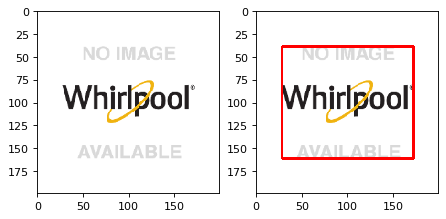

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:True
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:True
Padding_Percent:1.236
is_Scene:False
Image_DataType:image/png
Image_Shape:(200, 200, 3)
Bound_Box:[(28, 39), (172, 162)]
statusCode:200


In [10]:
noImage_img='https://www.whirlpool.com/is/image/content/dam/global/shot-lists/2018/p180477/hero-72032-1.tif?$mdm-thumb-290$'
analyzeImage(noImage_img)

Content Length: 4445
False
non white pixels percentage: 0.033622559652928416
https://www.whirlpool.com/is/image/content/dam/global/shot-lists/2018/p180507/hero-p180507-7z.tif
Padding Area is 0.0%


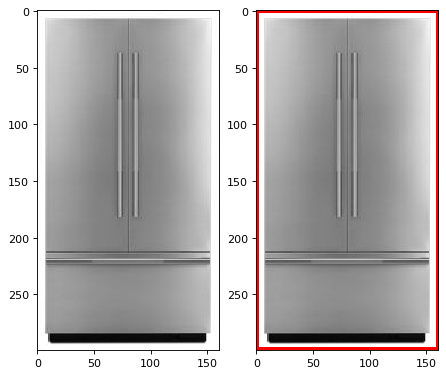

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:True
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:False
Padding_Percent:0.0
is_Scene:False
Image_DataType:image/jpeg
Image_Shape:(300, 161, 3)
Bound_Box:[(0, 0), (160, 299)]
statusCode:200


In [11]:
tif_file = 'https://www.whirlpool.com/is/image/content/dam/global/shot-lists/2018/p180507/hero-p180507-7z.tif'
analyzeImage(tif_file)

Content Length: 147309
False
non white pixels percentage: 0.3520408163265306
https://www.riverside-furniture.com/images/get/7/10244-v2.jpg
Padding Area is 23552.9%


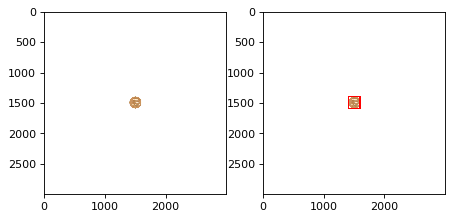

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:False
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:True
Padding_Percent:235.529
is_Scene:False
Image_DataType:image/jpeg
Image_Shape:(3000, 3000, 3)
Bound_Box:[(1401, 1402), (1596, 1597)]
statusCode:200


In [12]:
f = 'https://www.riverside-furniture.com/images/get/7/10244-v2.jpg'
analyzeImage(f)

Content Length: 896099
False
non white pixels percentage: 0.3298841059602649
http://products.geappliances.com/MarketingObjectRetrieval/Dispatcher?RequestType=Image&Name=CGI69967.jpg
Padding Area is 2.9%


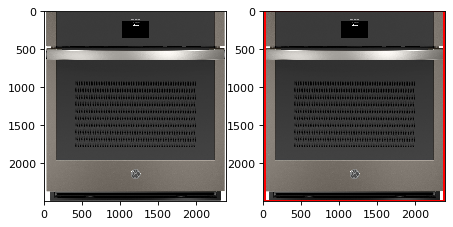

URL_Status_Code:200
Invalid_ContentLength:False
Low_Resolution:False
Resolution_TooHigh:False
Unsupported_ImageType:False
Require_Crop:False
Padding_Percent:0.029
is_Scene:False
Image_DataType:image/jpeg
Image_Shape:(2500, 2400, 3)
Bound_Box:[(31, 3), (2369, 2495)]
statusCode:200


In [13]:
f = 'http://products.geappliances.com/MarketingObjectRetrieval/Dispatcher?RequestType=Image&Name=CGI69967.jpg'
analyzeImage(f)